In [3]:
%pwd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data_dir = "./Data/Weather/"
%matplotlib inline
!mkdir -p $data_dir
!ls $data_dir

SampleStations.pickle  STAT.pickle


### Downloading Pickled data from S3
If `SampleStations.pickle` is not in the directory, get it using the following command

In [3]:
!curl -o $data_dir/SampleStations.pickle http://mas-dse-open.s3.amazonaws.com/Weather/SampleStations.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  398M  100  398M    0     0  2718k      0  0:02:30  0:02:30 --:--:--  952k


### Plot Reconstructions

From each measurement, we take 2 sample stations with low residual error and 2 sample stations with high residual error and plot the following:

* Original Data Vector
* Mean Vector
* Reconstructed Data Vector using mean and top 1 eigen vectors
* Reconstructed Data Vector using mean and top 2 eigen vectors
* Reconstructed Data Vector using mean and top 3 eigen vectors

### Read and Preprocess data

Read data from the pickle files `SampleStations.pickle` and `STAT.pickle`

* `SampleStations.pickle` contains information about the 6 measurements taken from some sample stations. You have been provided the code to process this file. It converts the seemingly complicated structure into a list of lists where each sublist has the following information:

`['station','measurement','year','1', '2', '3', ...... , '365']`

*  station - The station ID
*  measurement - One of the 6 types of measurements
*  year - The year in which the measurements were recorded
*  1-365 - The actual value of measurement for each day of the year



* `STAT.pickle` contains statistics about the weather data for each of the 6 measurements and its description.

In [5]:
import pickle
Data = pickle.load(open('./Data/Weather/SampleStations.pickle' ,'r'))
STAT, STAT_description = pickle.load(open('./Data/Weather/STAT.pickle' ,'r'))

In [6]:
# flat the data into ['station','measurement','year','1', '2', '3', ...... , '365']
FlatData=[]
for station in Data:
    stationname = station[0]
    for measurements in station[1]:
        measurement, year = measurements[0]
        yeardata = list(measurements[1])
        rowData = [stationname] + [measurement] + [year] + yeardata
        FlatData.append(rowData)

In [8]:
import pandas as pd

# convert to panda data frame
frameheader = ['station', 'measurement', 'year'] + range(1,366)
df = pd.DataFrame(FlatData, columns=frameheader)  

# mapping measurements 
m_df = {}
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    t_df = df[df['measurement'] == m]
    m_df[m] = t_df    

### Define Reconstruction Function

You need to plot reconstructions for two stations with low reconstruction error and two stations with high reconstruction error. To do this, you will need to do the following:

1. Calculate the reconstruction error for the data vector reconstructed using mean and top-3 eigenvectors.
2. Remove the ones for which reconstruction error is NaN.
3. Choose two with the lowest and two with the highest reconstruction error for plotting.

Use column vector as convetion 
* T: stations $\times$ years
* dim: 365

In [57]:
# deprecated 
def reconstruction_error(v0, v):
    diff = v0-v
    return np.dot(diff, diff)


# deprecated, eigens are given 
def PCA(m_df, meas):
    X = m_df[meas].values  # dataframe to numpy array 
    X = X.T
    X = X[3:, :]  # truncate first 3 columns of non-measures
    X = np.array(X, dtype=np.float64)
    print X
    d, T = X.shape
    mu = 1.0/T * np.sum(X, axis=1)
    X = X - np.repeat(mu[:, np.newaxis], T, axis=1)
    
    # use SVD on X to economically calculate eigen decomposition on XX'
    eigvec, singval, vari = np.linalg.svd(X, full_matrices=False)
    egival = np.power(singval, 2) / T
    
    idxes = np.argsort(egival)[::-1]
    eigvec, egival = eigvec[:, idxes], egival[idxes]
    
    return mu, eigvec, egival

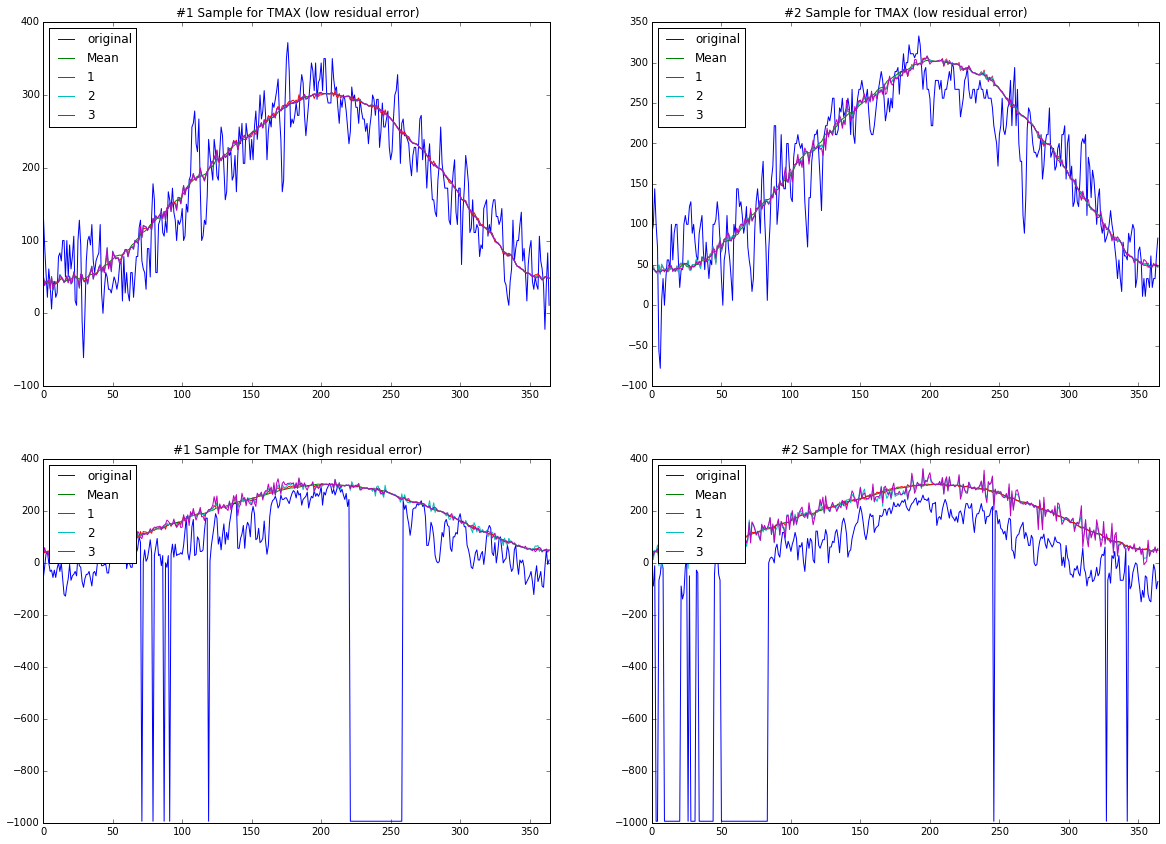

In [102]:
def create_reconstructions(m):  
    
    ## Begin Solution Code
    # Notice: eigs and means are given 
    Reconstructed = [None] # TODO
    DIM = 365
    
    eigvecs = STAT[m]['eigvec']
    
    X = m_df[m].values  # dataframe to numpy array 
    X = X.T
    X = X[3:, :]  # truncate first 3 columns of non-measures
    X = np.array(X, dtype=np.float64)
    
    d, T = X.shape
    assert d == DIM
    
    mu = STAT[m]['Mean']
    X_centered = X - np.repeat(mu[:, np.newaxis], T, axis=1)
    for k in xrange(1, 4):
        U = np.array([eigvecs[i] for i in xrange(k)])
        U = U.T
        
        assert U.shape[0] == DIM  # col vector 
        X_recon = np.dot(U, np.dot(U.T, X_centered))  # dot is matrix multiplication 
        X_recon += np.repeat(mu[:, np.newaxis], T, axis=1)
        Reconstructed.append(X_recon)

    # reconstruction error 
    diff = X - Reconstructed[3]
    error_recon = np.sum(np.power(diff, 2), axis=0)
    
    idxes = ~numpy.isnan(error_recon)
    X = X[:, idxes]
    error_recon = error_recon[idxes]
    for k in xrange(1, 4): Reconstructed[k] = Reconstructed[k][:, idxes]

    idxes = np.argsort(error_recon)
    lower = idxes[:2]
    upper = idxes[-2:]
    original = X.T    
    ## End
    
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,30), dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0, 365])
        legend(['original','Mean','1','2','3'], loc=2)
    
    c=0
    for l in upper:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0, 365])
        legend(['original','Mean','1','2','3'], loc=2)

create_reconstructions('TMAX')

Reconstruction Plots for TMAX
Reconstruction Plots for SNWD


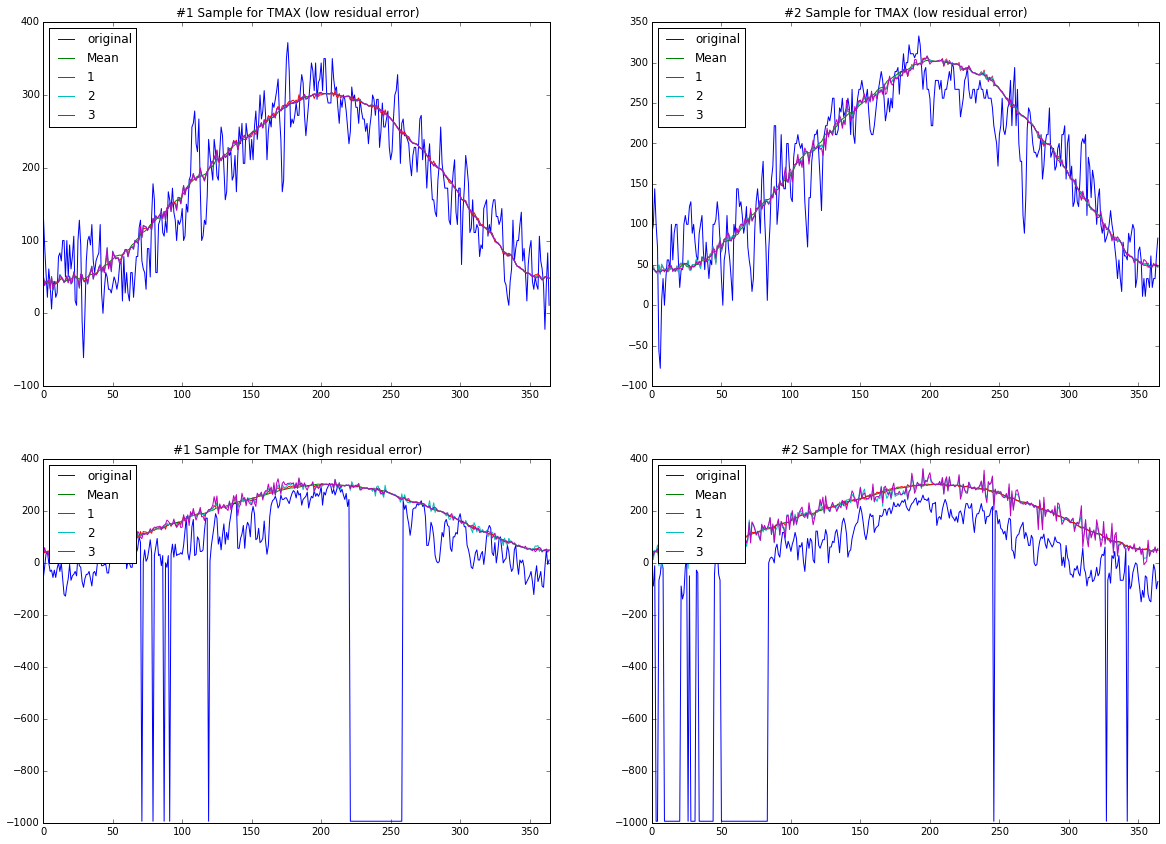

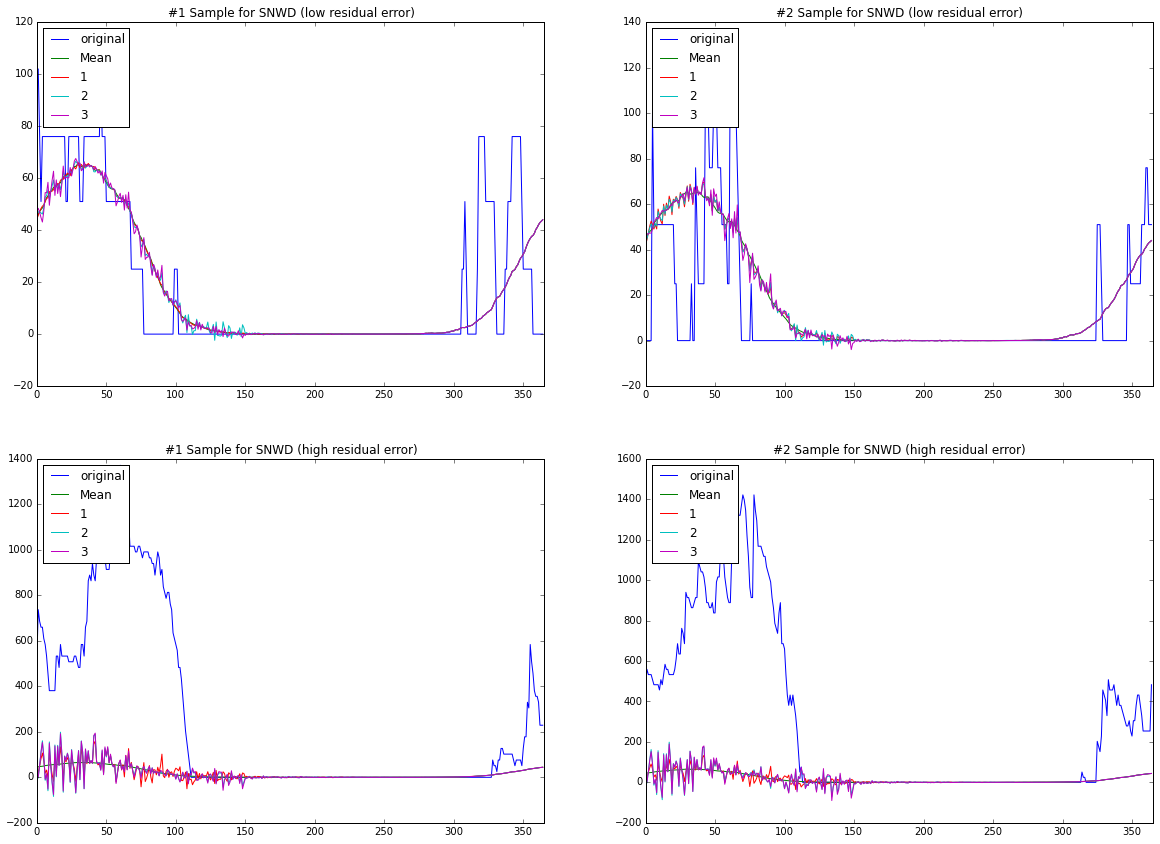

In [103]:
for m in ['TMAX','SNWD']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)